In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
# import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import multiprocessing
import time

from sklearn.preprocessing import normalize
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn import metrics
from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances

#pd.options.display.max_rows = 999

# Clustering Boston Marathon Runners

We'll use information on runners and their performance for the Boston Marathon to determine which clustering solution, including number of clusters and algorithm used, is best.

The data set was collected from www.baa.org and obtained from https://github.com/llimllib/bostonmarathon.

## Load the data set and create features
We'll start by manually creating features and clusters, then comparing their similarities with the **K-means, Mean Shift, and Spectral Clustering** clustering methods.

In [3]:
cols = ['genderdiv', 'gender', 'age', '10k', '20k', '25k', '30k', '35k', '40k', 'pace']

data = pd.read_csv('bm_2014_results.csv', usecols=cols)[cols]

data['age_group'] = pd.cut(data['age'], range(18,85,9))

### Create Ranking Groups
We'll manually group runners into 11 categories, according to their gender, age group, and ranking in the marathon (1st Place Male/Female, 2nd place, 3rd place, top 10, top 50, top 100, etc...).

The resulting feature has 99 classes and will serve as our "ground truth" to compare clustering solutions.

In [4]:
rankings = [1, 2, 3, 10, 50, 100, 200, 500, 1000, 5000, 10000]

data['ranking_group'] = np.nan

for i in rankings:
    for j in data.age_group.unique():
        for k in ['M', 'F']:
            data.loc[(data.genderdiv>=i) & (data.age_group==j) & (data.gender==k),
                     ['ranking_group']] = str(i) + str(j) + k

data.head()

,genderdiv,gender,age,10k,20k,25k,30k,35k,40k,pace,age_group,ranking_group
0,8,M,47,17.37,37.65,47.67,59.18,71.40,80.43,3.27,"(45, 54]","3(45, 54]M"
1,1,F,33,32.58,65.83,82.43,99.33,116.37,132.10,5.30,"(27, 36]","1(27, 36]F"
2,1,M,41,16.62,36.10,45.80,56.45,67.42,76.10,3.08,"(36, 45]","1(36, 45]M"
3,3,F,24,32.57,65.83,82.43,99.33,116.37,132.95,5.37,"(18, 27]","3(18, 27]F"
4,2,M,40,17.12,36.58,46.37,57.03,67.83,76.72,3.10,"(36, 45]","2(36, 45]M"


In [5]:
cols = ['10k', '20k', '25k', '30k', '35k', '40k', 'pace']

data[cols] = data[cols].apply(pd.to_numeric, errors='coerce')

print(data.shape)
data.dropna(inplace=True)
print(data.shape)

(31984, 12)
(31674, 12)


### Preview average running times by age group and gender

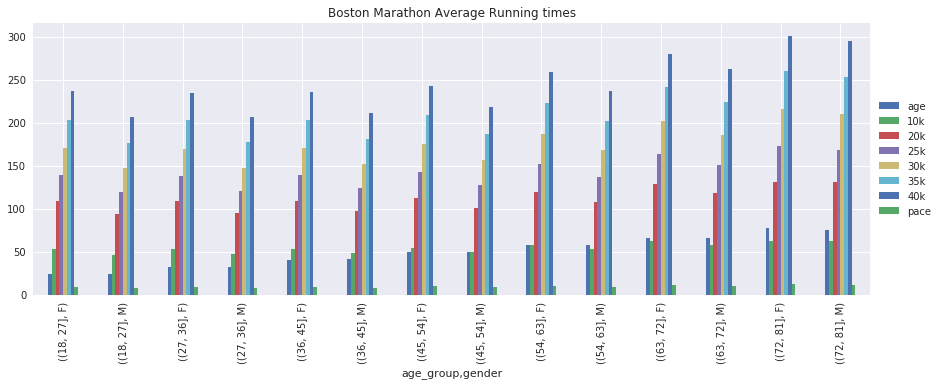

In [6]:
data.iloc[:,1:-1].groupby(['age_group', 'gender']).mean().plot(kind='bar', figsize=(15,5))
plt.title('Boston Marathon Average Running times')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Normalize continuous variables

In [7]:
cols = ['10k', '20k', '25k', '30k', '35k', '40k', 'pace', 'age']

norm_data = pd.DataFrame(data=normalize(data[cols]), columns=cols)

# Binarize gender so that 1 means Male and 0 means Female
norm_data['gender'] = np.where(data.gender=='M', 0, 1)

### Create numerical labels for each Ranking Group Class
We'll use SKlearn's Label Encoder to create numerical labels for each ranking group classes. The labels are assigned to classes in alphabetical order.

In [8]:
le = preprocessing.LabelEncoder()

norm_data['ranking_group'] = le.fit_transform(data.ranking_group)

print('Ranking Group Classes:')
[i for i in enumerate(le.classes_)]

Ranking Group Classes:


[(0, '1(18, 27]F'),
 (1, '1(27, 36]F'),
 (2, '1(36, 45]M'),
 (3, '10(18, 27]F'),
 (4, '10(18, 27]M'),
 (5, '10(27, 36]F'),
 (6, '10(27, 36]M'),
 (7, '10(36, 45]F'),
 (8, '10(36, 45]M'),
 (9, '10(45, 54]F'),
 (10, '10(45, 54]M'),
 (11, '10(54, 63]M'),
 (12, '100(18, 27]F'),
 (13, '100(18, 27]M'),
 (14, '100(27, 36]F'),
 (15, '100(27, 36]M'),
 (16, '100(36, 45]F'),
 (17, '100(36, 45]M'),
 (18, '100(45, 54]F'),
 (19, '100(45, 54]M'),
 (20, '100(54, 63]F'),
 (21, '1000(18, 27]F'),
 (22, '1000(18, 27]M'),
 (23, '1000(27, 36]F'),
 (24, '1000(27, 36]M'),
 (25, '1000(36, 45]F'),
 (26, '1000(36, 45]M'),
 (27, '1000(45, 54]F'),
 (28, '1000(45, 54]M'),
 (29, '1000(54, 63]F'),
 (30, '1000(54, 63]M'),
 (31, '1000(63, 72]F'),
 (32, '1000(63, 72]M'),
 (33, '10000(18, 27]F'),
 (34, '10000(18, 27]M'),
 (35, '10000(27, 36]F'),
 (36, '10000(27, 36]M'),
 (37, '10000(36, 45]F'),
 (38, '10000(36, 45]M'),
 (39, '10000(45, 54]F'),
 (40, '10000(45, 54]M'),
 (41, '10000(54, 63]F'),
 (42, '10000(54, 63]M'),
 (43

In [9]:
norm_data.head()

,10k,20k,25k,30k,35k,40k,pace,age,gender,ranking_group
0,0.119072,0.258091,0.326778,0.405680,0.489448,0.551349,0.022416,0.322186,0,66
1,0.139987,0.282854,0.354179,0.426794,0.500010,0.567598,0.022773,0.141792,1,1
2,0.120922,0.262653,0.333227,0.410713,0.490527,0.553680,0.022409,0.298303,0,2
3,0.140317,0.283608,0.355123,0.427932,0.501343,0.572773,0.023135,0.103396,1,60
4,0.123778,0.264474,0.335256,0.412328,0.490412,0.554687,0.022413,0.289201,0,50


### Create PCA components for graphing purposes
We'll create two PCA components to visualize scatterplots of the data and clusters.

In [10]:
# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)

X_pca = pca.fit_transform(norm_data.iloc[:,:-1])

# Inspect components' variance ratios
print('PCA components:\n', pca.explained_variance_ratio_)
print('\nThe percentage of total variance in the dataset explained by components:\n',
      sum(pca.explained_variance_ratio_))

norm_data['pca_1'], norm_data['pca_2'] = X_pca.T[0], X_pca.T[1]

norm_data.head()

PCA components:
 [0.99459235 0.00375164]

The percentage of total variance in the dataset explained by components:
 0.9983439910452732


,10k,20k,25k,30k,35k,40k,pace,age,gender,ranking_group,pca_1,pca_2
0,0.119072,0.258091,0.326778,0.405680,0.489448,0.551349,0.022416,0.322186,0,66,-0.452842,0.194076
1,0.139987,0.282854,0.354179,0.426794,0.500010,0.567598,0.022773,0.141792,1,1,0.551229,0.047634
2,0.120922,0.262653,0.333227,0.410713,0.490527,0.553680,0.022409,0.298303,0,2,-0.452251,0.172209
3,0.140317,0.283608,0.355123,0.427932,0.501343,0.572773,0.023135,0.103396,1,60,0.552121,0.010117
4,0.123778,0.264474,0.335256,0.412328,0.490412,0.554687,0.022413,0.289201,0,50,-0.452028,0.164089


## Create Clusters
We'll use the K-Means, Mean Shift, and Spectral Clustering methods.

Clusters will be tested with the *Adjusted Rand Score* and *Silhouette Score* methods.

In [11]:
# Create clusters from PCA components

norm_data['k_means_'] = KMeans(n_clusters=99, random_state=42).fit_predict(norm_data[['pca_1', 'pca_2']])

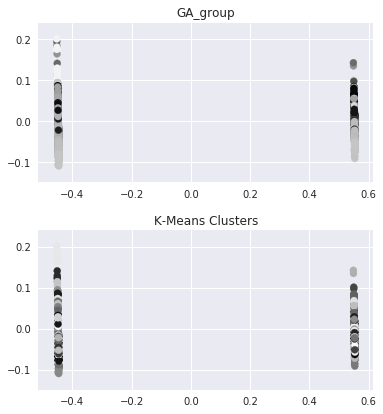

In [11]:
# Make a grid of subplots.
f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)

plt.subplots_adjust(top=1.4, hspace=.3)

ax1.scatter(norm_data.pca_1, norm_data.pca_2, c=norm_data.ranking_group)
ax1.set_title('GA_group')

ax2.scatter(norm_data.pca_1, norm_data.pca_2, c=norm_data.k_means_)
ax2.set_title('K-Means Clusters')

plt.show()

Up to 99.45% of the data variance is explained by the first PCA component, so the graph isn't very useful. Let's see how *K-Means* compares with our *Ranking Group* feature using the *Adjusted Rand Score* method.

## Calculate the Adjusted Rand Score

In [12]:
metrics.adjusted_rand_score(norm_data.ranking_group, norm_data.k_means_)

0.09386974463723348

The ARS score is very low, almost equal to zero (which would indicate a similarity score equivalent to random labeling).

The main reason is because our "ground truth" feature has its labels assigned to each class in alphabetical order. K-Means, on the other hand, assigns cluster labels according to their index location in the feature space, relative to the origin. 

**In this context, the Adjusted Rand Score is not useful since it is comparing two variables with mismatched labels.**

## Evaluate clusters by their Silhouette Scores
The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. This metric should be more useful to evaluate our data set.

#### K-Means with 99 clusters and PCA Components

In [13]:
# Start the timer function
start_time = time.time()

# This "if" statement makes models run in the main program to prevent infinite multi-processing loops
if __name__ == '__main__':
  multiprocessing.set_start_method('forkserver', force=True)

  model = KMeans(n_clusters=99, random_state=42, n_jobs=-1).fit(norm_data[['pca_1', 'pca_2']])

  Kmeans_labels = model.labels_

  print(metrics.silhouette_score(norm_data[['pca_1', 'pca_2']],
                                 Kmeans_labels, metric='euclidean', n_jobs=-1))
  
# Stop the timer function and inspect the time taken to run the method
print("\n--- %s seconds ---" % (time.time() - start_time))

0.5036658683175592

--- 85.2407717704773 seconds ---


#### K-Means with 99 clusters and the original data set (as opposed to PCA components)

In [18]:
# Start the timer function
start_time = time.time()

# This "if" statement makes models run in the main program to prevent infinite multi-processing loops
if __name__ == '__main__':
  multiprocessing.set_start_method('forkserver', force=True)

  model = KMeans(n_clusters=99, random_state=42, n_jobs=-1).fit(norm_data.iloc[:,:-4])

  KMeans_labels = model.labels_

  print(metrics.silhouette_score(norm_data.iloc[:,:-4], KMeans_labels, metric='euclidean', n_jobs=-1))

# Stop the timer function and inspect the time taken to run the method
print("\n--- %s seconds ---" % (time.time() - start_time))

0.2243625713573295

--- 99.469309091568 seconds ---


#### K-Means with 13 clusters and PCA Components

In [18]:
# Start the timer function
start_time = time.time()

# This "if" statement makes models run in the main program to prevent infinite multi-processing loops
if __name__ == '__main__':
  multiprocessing.set_start_method('forkserver', force=True)

  model = KMeans(n_clusters=13, random_state=42, n_jobs=-1).fit(norm_data[['pca_1', 'pca_2']])

  Kmeans_labels = model.labels_

  print(metrics.silhouette_score(norm_data[['pca_1', 'pca_2']],
                                 Kmeans_labels, metric='euclidean', n_jobs=-1))
  
# Stop the timer function and inspect the time taken to run the method
print("\n--- %s seconds ---" % (time.time() - start_time))

0.5160338657508017

--- 101.86600589752197 seconds ---


#### Mean Shift with PCA components

In [17]:
# This "if" statement makes models run in the main program to prevent infinite multi-processing loops
if __name__ == '__main__':
  multiprocessing.set_start_method('forkserver', force=True)

  # Start the timer function
  start_time = time.time()
  
  # Declare and fit the model.
  ms = MeanShift(bin_seeding=False)
  ms.fit(norm_data[['pca_1', 'pca_2']])

  # Extract cluster assignments for each data point.
  ms_labels = ms.labels_

  # Coordinates of the cluster centers.
  cluster_centers = ms.cluster_centers_

  # Count our clusters.
  n_clusters_ = len(np.unique(ms_labels))

  print("Number of estimated clusters: {}".format(n_clusters_))
  
  print(metrics.silhouette_score(norm_data[['pca_1', 'pca_2']], ms_labels, metric='euclidean', n_jobs=-1))

  # Stop the timer function and inspect the time taken to run the method
  print("\n--- %s seconds ---" % (time.time() - start_time))

Number of estimated clusters: 3
0.8253667608087268

--- 434.174040555954 seconds ---


#### Mean Shift with the original data set

In [26]:
# This "if" statement makes models run in the main program to prevent infinite multi-processing loops
if __name__ == '__main__':
  multiprocessing.set_start_method('forkserver', force=True)

  # Start the timer function
  start_time = time.time()
  
  # Declare and fit the model.
  ms = MeanShift(bin_seeding=False)
  ms.fit(norm_data.iloc[:,:-4])

  # Extract cluster assignments for each data point.
  ms_labels = ms.labels_

  # Coordinates of the cluster centers.
  cluster_centers = ms.cluster_centers_

  # Count our clusters.
  n_clusters_ = len(np.unique(ms_labels))

  print("Number of estimated clusters: {}".format(n_clusters_))
  
  print(metrics.silhouette_score(norm_data.iloc[:,:-4], ms_labels, metric='euclidean', n_jobs=-1))

  # Stop the timer function and inspect the time taken to run the method
  print("\n--- %s seconds ---" % (time.time() - start_time))

Number of estimated clusters: 13
0.45393098902644047

--- 816.4197702407837 seconds ---


#### Spectral clustering is killing the kernel:

Spectral Clustering requires a lot of memory and is killing the kernel. This notebook is running in a machine with 8 vCPUs and 17.25 GB memory.

In [ ]:
# Start the timer function
start_time = time.time()

# Declare and fit the model.
sc = SpectralClustering(n_clusters=13)
sc.fit(norm_data.iloc[:,:-4])

#Predicted clusters.
sc_predict = sc.fit_predict(norm_data.iloc[:,:-4])

print(metrics.silhouette_score(norm_data.iloc[:,:-4], sc_predict, metric='euclidean'))

# Stop the timer function and inspect the time taken to run the method
print("\n--- %s seconds ---" % (time.time() - start_time))

#### Silhouette Score of the hand-made "Ranking Group" cluster

In [30]:
# This "if" statement makes models run in the main program to prevent infinite multi-processing loops
if __name__ == '__main__':
  multiprocessing.set_start_method('forkserver', force=True)
  
  # Start the timer function
  start_time = time.time()
  
  print(metrics.silhouette_score(norm_data.iloc[:,:-4], norm_data.ranking_group,
                                 metric='euclidean', n_jobs=-1))
  
  # Stop the timer function and inspect the time taken to run the method
  print("\n--- %s seconds ---" % (time.time() - start_time))

-0.19425060295874214

--- 84.62534213066101 seconds ---


## Conclusion

The best clustering method proved to be K-Means and 13 clusters, with a silhouette score of 0.516. Breaking down the data into 99 clusters introduces randomness, as some clusters end up with just one or two observations.

Although the highest silhouette score (0.825) was obtained by Mean Shift and PCA data, the model resulted in just three clusters. The utility of such few clusters is questionable.

The negative silhouette score of our "hand-made Ranking Group clusters" indicates that although it may make sense on a social perspective (it is, after all, how marathon outcomes are ranked), the ranking produces heterogenous groups.